### Moodboard on Playlists

In [1]:
!pip install requests --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CLIENT_ID = '11ce0f19485642d9a7ead084b4d6f7e9'
CLIENT_SECRET = '6f859648f6b64d659e7b6f3f309c1eaf'

In [3]:
auth_response = requests.post('https://accounts.spotify.com/api/token',
    {'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET}).json()
access_token = auth_response['access_token']
HEADERS = {'Authorization': 'Bearer {token}'.format(token=access_token)}

### To test on your own playlist, use the text after "/playlist/" and before "?"

In [7]:
# Base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Id of playlist
# playlist_id = '37i9dQZF1DX4SBhb3fqCJd' 
playlist_id = '2kUlqhddlSFjPcY6FmK4qg' 
# playlist title "110": https://open.spotify.com/playlist/5fu8CDQyQSx2dMyQpEnc7J?si=82f2411c9ab1436c

In [8]:
# some example playlists: 
# playlist title: "vitamin d deficiency?": https://open.spotify.com/playlist/2kUlqhddlSFjPcY6FmK4qg?si=7b18038b19044718

## Return metadata from a given track

In [9]:
def get_track_data(track_id):
    """ Given track_id, returns a dictionary
        containing the track's catalog information
        (e.g. name, artists, genres) and audio feature
        metadata (e.g. tempo, key, energy).
    """
    # Get each track's audio features
    audio = requests.get(BASE_URL + 'audio-features/' + track_id,
                         headers=HEADERS).json()
    # Get each track's catalog information
    track = requests.get(BASE_URL + 'tracks/' + track_id,
                         headers=HEADERS).json()
    artists = []
    genres = []
    for artist in track['artists']:
        artist_id = artist['id']
        artist_genres = requests.get(BASE_URL + 'artists/' + artist_id,
                                     headers=HEADERS).json()['genres']
        artists.append(artist['name'])
        genres.append(artist_genres)
    genres = [item for sublist in genres for item in sublist] # Flatten list
    
    # Combine into one dictionary and return
    audio.update({
        'name': track['name'],
        'artists': artists,
        'genres': genres,
        'popularity': track['popularity'],
        'explicit': track['explicit']
    })
    return audio

In [10]:
# sample track to test function
sample_track_id = '1Ist6PR2BZR3n2z2Y5R6S1'
get_track_data(sample_track_id)

{'danceability': 0.566,
 'energy': 0.647,
 'key': 1,
 'loudness': -6.815,
 'mode': 0,
 'speechiness': 0.0335,
 'acousticness': 0.0477,
 'instrumentalness': 0,
 'liveness': 0.121,
 'valence': 0.22,
 'tempo': 111.96,
 'type': 'audio_features',
 'id': '1Ist6PR2BZR3n2z2Y5R6S1',
 'uri': 'spotify:track:1Ist6PR2BZR3n2z2Y5R6S1',
 'track_href': 'https://api.spotify.com/v1/tracks/1Ist6PR2BZR3n2z2Y5R6S1',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Ist6PR2BZR3n2z2Y5R6S1',
 'duration_ms': 264773,
 'time_signature': 4,
 'name': 'Summertime Sadness',
 'artists': ['Lana Del Rey'],
 'genres': ['art pop', 'pop'],
 'popularity': 76,
 'explicit': False}

## Represent the playlist in a DataFrame

In [11]:
def get_playlist_data(playlist_id):
    """ Given playlist_id, returns a pandas DataFrame
        containing information on each track.
    """
    playlist_length = 50
    data = [] # Will contain info about the tracks on the playlist
    counter = 0 # Number of tracks appended to data

    while counter < playlist_length:
        limit = min(50, playlist_length-counter)
        playlist = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks',
                                headers=HEADERS,
                                params={'limit': limit, 'offset': counter}).json()
        if counter==0:
            playlist_length = playlist['total']
        counter = min(counter+50, playlist_length) # Update counter
    
        for item in playlist['items']:
            data.append(get_track_data(item['track']['id']))
    df = pd.DataFrame(data)
    return df

In [12]:
playlist_df = get_playlist_data(playlist_id)
playlist_df.head(10) # View first 8 entries of dataframe

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit
0,0.895,0.309,10,-18.614,1,0.0911,0.9360,0.966000,0.0826,0.919,...,spotify:track:4RBVWdDXchRIX4n3Fpnzvy,https://api.spotify.com/v1/tracks/4RBVWdDXchRI...,https://api.spotify.com/v1/audio-analysis/4RBV...,153277,4,Teenage Dream x Put Your Records On,[Darcy Stokes],[],0,False
1,0.426,0.872,10,-3.322,1,0.1150,0.0191,0.000000,0.2690,0.608,...,spotify:track:0oigSejhoNen2EdNAIFcm5,https://api.spotify.com/v1/tracks/0oigSejhoNen...,https://api.spotify.com/v1/audio-analysis/0oig...,187693,4,Hollywood Baby,[100 gecs],"[bubblegum bass, hyper-rock, hyperpop, proto-h...",59,True
2,0.816,0.375,7,-8.053,1,0.0996,0.6070,0.000009,0.0933,0.615,...,spotify:track:451GvHwY99NKV4zdKPRWmv,https://api.spotify.com/v1/tracks/451GvHwY99NK...,https://api.spotify.com/v1/audio-analysis/451G...,191907,4,Banana Pancakes,[Jack Johnson],[neo mellow],71,False
3,0.378,0.638,10,-5.576,1,0.0750,0.0200,0.000077,0.0849,0.735,...,spotify:track:7a86XRg84qjasly9f6bPSD,https://api.spotify.com/v1/tracks/7a86XRg84qja...,https://api.spotify.com/v1/audio-analysis/7a86...,250627,4,We Are Young (feat. Janelle Monáe),"[fun., Janelle Monáe]","[baroque pop, metropopolis, afrofuturism, alte...",74,False
4,0.483,0.777,4,-5.049,1,0.0618,0.0170,0.000019,0.2090,0.572,...,spotify:track:1Pyxh8ERS8aouSSOQVvVsz,https://api.spotify.com/v1/tracks/1Pyxh8ERS8ao...,https://api.spotify.com/v1/audio-analysis/1Pyx...,252560,4,Sour Patch Kids,[Bryce Vine],[indie pop rap],0,True
5,0.787,0.655,6,-8.339,0,0.0431,0.2380,0.000171,0.1380,0.650,...,spotify:track:6shRGWCtBUOPFLFTTqXZIC,https://api.spotify.com/v1/tracks/6shRGWCtBUOP...,https://api.spotify.com/v1/audio-analysis/6shR...,208653,4,Upside Down,[Jack Johnson],[neo mellow],71,False
6,0.614,0.840,7,-5.355,1,0.1090,0.0436,0.000416,0.3000,0.524,...,spotify:track:4x0ZEnpVD3venpJfaKRYcB,https://api.spotify.com/v1/tracks/4x0ZEnpVD3ve...,https://api.spotify.com/v1/audio-analysis/4x0Z...,168962,4,Pickles from the Jar,[Courtney Barnett],"[art pop, australian indie, chamber pop, indie...",1,False
7,0.652,0.568,7,-8.205,1,0.0363,0.4820,0.000000,0.0945,0.856,...,spotify:track:07gqJjvwwuZ1assFLKbiNn,https://api.spotify.com/v1/tracks/07gqJjvwwuZ1...,https://api.spotify.com/v1/audio-analysis/07gq...,117667,4,Dance Music,[The Mountain Goats],"[anti-folk, chamber pop, folk punk, indie rock...",0,False
8,0.615,0.658,5,-7.299,1,0.0343,0.0960,0.000911,0.2050,0.293,...,spotify:track:3n69hLUdIsSa1WlRmjMZlW,https://api.spotify.com/v1/tracks/3n69hLUdIsSa...,https://api.spotify.com/v1/audio-analysis/3n69...,227080,4,Breezeblocks,[alt-J],"[indie rock, indietronica, modern alternative ...",71,False
9,0.517,0.481,5,-8.273,1,0.0272,0.0293,0.000018,0.0903,0.461,...,spotify:track:6JnufVNLIO5F5Lk4sEVLeI,https://api.spotify.com/v1/tracks/6JnufVNLIO5F...,https://api.spotify.com/v1/audio-analysis/6Jnu...,246973,4,Little Lion Man,[Mumford & Sons],"[modern folk rock, modern rock, neo mellow, st...",0,True


# Some data analysis to gain further insight into the data

## Finding the song that has the highest valence in the playlist 

In [13]:
# Sort the DataFrame by valence in descending order
sorted_playlist = playlist_df.sort_values(by='valence', ascending=False)

In [14]:
# Get the happiest song
highest_valence = sorted_playlist.head(1).reset_index()
print("Happiest Song:")
print(highest_valence[[ 'name', 'valence']])

Happiest Song:
     name  valence
0  Talent     0.97


### Look up the valence of a given song in the playlist

In [15]:
# lookup valence of a given song in the playlist
song_name = "Breezeblocks" 

# Get the index of the song
index_of_song = playlist_df[playlist_df['name'] == song_name].index[0]

# Get the valence of the song
valence_of_song = playlist_df.loc[index_of_song, 'valence']

print(f"Valence of '{song_name}': {valence_of_song}")

Valence of 'Breezeblocks': 0.293


### Visualize artist counts of playlist

In [16]:
# Flatten into one list of all artist names
all_artists = [artist for artists in playlist_df['artists'] for artist in artists]
# Get counts of each artist using value_counts
artist_counts = pd.Series(all_artists).value_counts()
print(artist_counts)

Jack Johnson             3
Kid Quill                2
alt-J                    2
Natasha Bedingfield      2
Spose                    1
Bina Bianca              1
Ziggy Alberts            1
Lawrence                 1
The Chords               1
Katrina & The Waves      1
Mt. Joy                  1
The Avett Brothers       1
Royel Otis               1
Katie Lynne Sharbaugh    1
Akintoye                 1
Darcy Stokes             1
100 gecs                 1
Tai Verdes               1
Paula Fuga               1
Noah And The Whale       1
Neutral Milk Hotel       1
Mumford & Sons           1
The Mountain Goats       1
Courtney Barnett         1
Bryce Vine               1
Janelle Monáe            1
fun.                     1
sammy rash               1
Name: count, dtype: int64


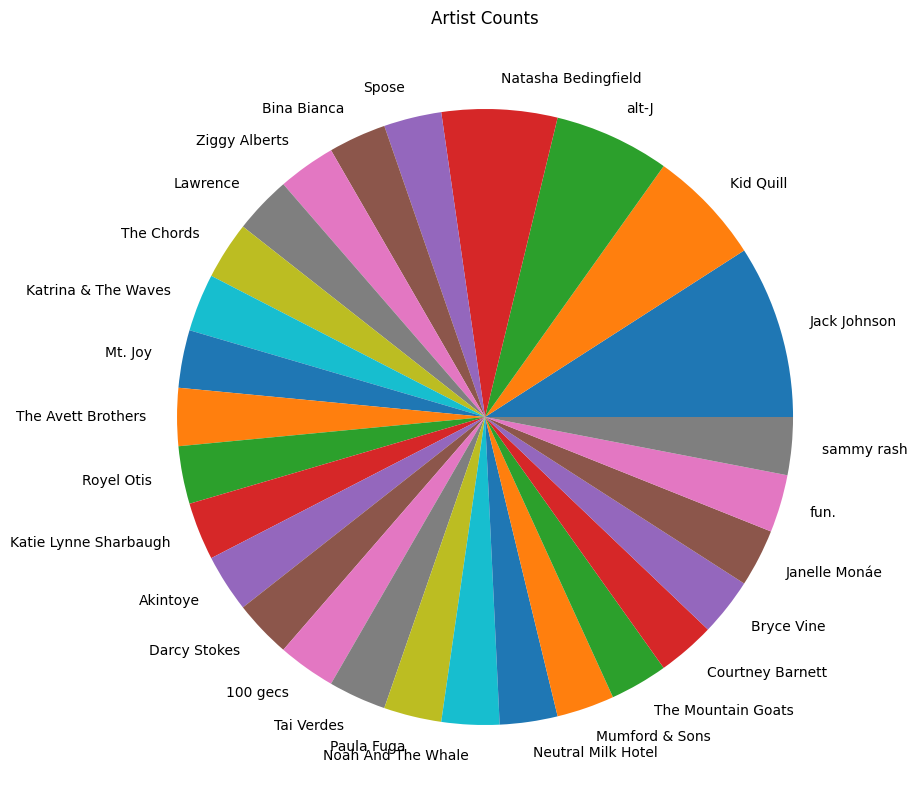

In [17]:
# represent visually
plt.figure(figsize=(10, 10))
# Type of graph (pie), specifying artist_counts as subject being graphed
plt.pie(artist_counts, labels=artist_counts.index)
# Give the plot a title
plt.title('Artist Counts')
# Show the plot
plt.show()

## See just the top 5 artists 

In [18]:
# Num of top artists
n = 5 
top_artists = artist_counts.head(n)
other_artists = artist_counts.iloc[n:].sum()
# Concatenate two Series
artist_counts_adjusted = pd.concat([top_artists, pd.Series({'Other': other_artists})])


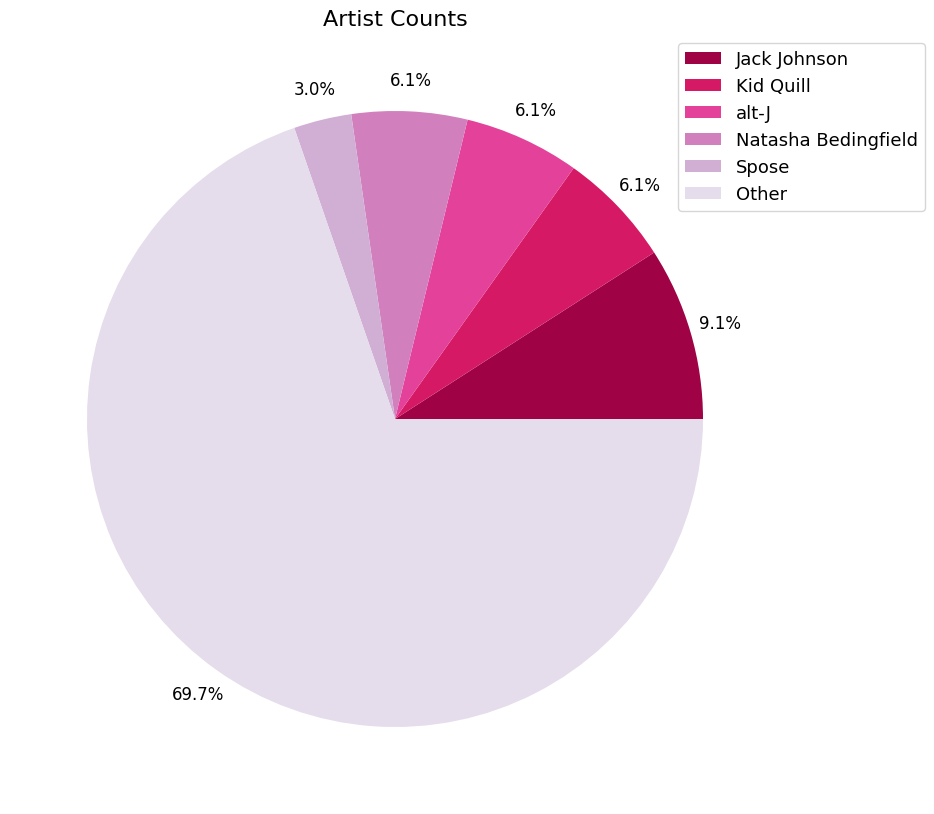

In [19]:
plt.figure(figsize=(10, 10))
plt.pie(
    artist_counts_adjusted, # Switched from artist_counts to artist_counts_adjusted
    autopct = '%.1f%%', # Displays percentage with 1 decimal place
    pctdistance = 1.1, # Relative distance of percentage from center of pie
    colors = sns.color_palette("PuRd_r"), # Apply seaborn color palette
    textprops = {'size': 12} # Font size
    )
plt.title(
    label = 'Artist Counts',
    fontdict={"fontsize":16} # Change font size of title
)
# Move labels to a legend
plt.legend(
    artist_counts_adjusted.index, 
    loc = "upper right", # Position of legend, relative to specified coordinates
    bbox_to_anchor = (1.2, 1), # Specify desired coordinates of legend
    prop = {'size': 13} # Font size
)
# Show the plot
plt.show()

### get key signature of a given song

In [20]:
# Define the key mapping, Numbers correspond to key signatures.
key_mapping = {
    0: 'C',
    1: 'C♯/D♭',
    2: 'D',
    3: 'D♯/E♭',
    4: 'E',
    5: 'F',
    6: 'F♯/G♭',
    7: 'G',
    8: 'G♯/A♭',
    9: 'A',
    10: 'A♯/B♭',
    11: 'B',
}

def get_song_info(df, song_name, info_key):
    """
    Given a DataFrame, song name, and desired information key,
    this function returns the desired feature of the given song.
    """
    # Encase in a try-catch so that if the song named is typed incorrectly 
    # or is not found within the df there won't be an error.
    try:
        # Case-insensitive search
        song_info_series = df[df['name'].str.lower() == song_name.lower()][info_key]
        if not song_info_series.empty:  # Check if the series is not empty
            song_info = song_info_series.values[0]  # Extract the first element
            return song_info
        else:
            print(f"Song '{song_name}' not found in the playlist.")
            return None
    except KeyError:
        print(f"Error: The column '{info_key}' does not exist in the DataFrame.")
        return None

In [21]:
# Test with the song Talent
song_name = "Talent"
info_key = "key"
song_key = get_song_info(playlist_df, song_name, info_key)

if song_key is not None: # "As long as the key is there"
    music_key = key_mapping.get(song_key, 'Note') # Call key mapping
    print(f'The key of "{song_name}" is {music_key}.')

The key of "Talent" is G.


### Visualizing how loud each song in the playlist is

In [22]:
# Sort values by loudness
loudness_sorted_df = playlist_df.sort_values(by='loudness')

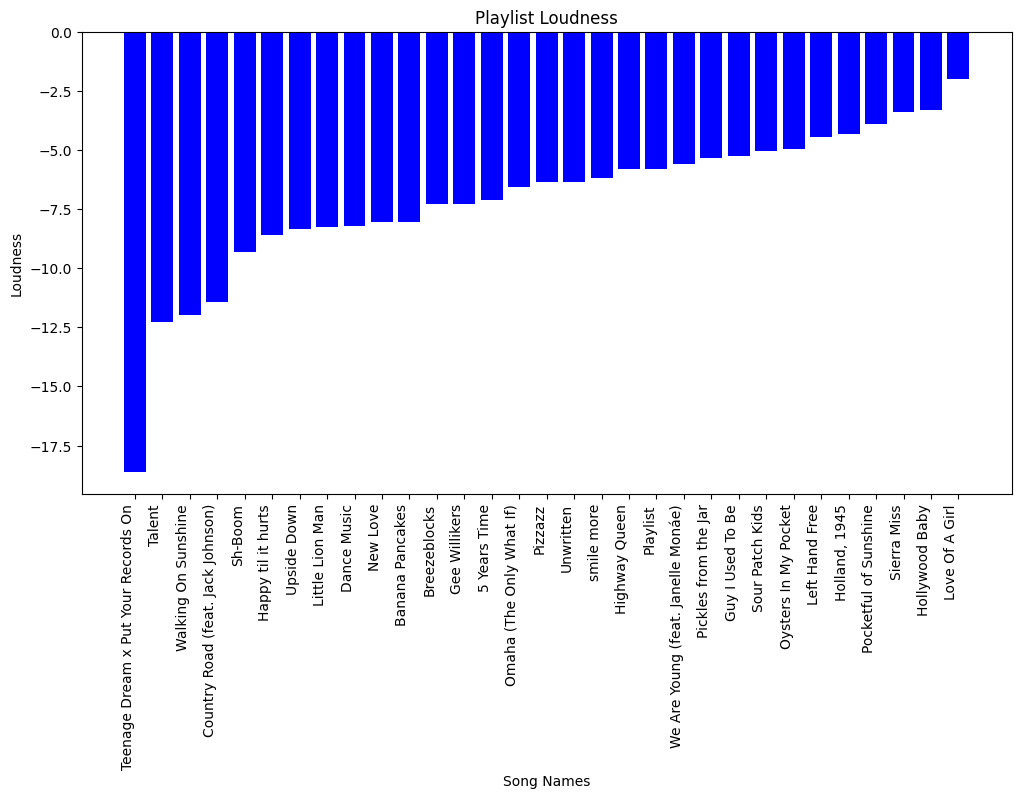

In [23]:
plt.figure(figsize=(12, 6))
plt.bar(loudness_sorted_df['name'], loudness_sorted_df['loudness'], color='blue')
plt.xlabel('Song Names')
plt.ylabel('Loudness')
plt.title('Playlist Loudness')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90, ha='right') 
# Show the plot
plt.show()

## Is there any correlation between danceability and valence? 

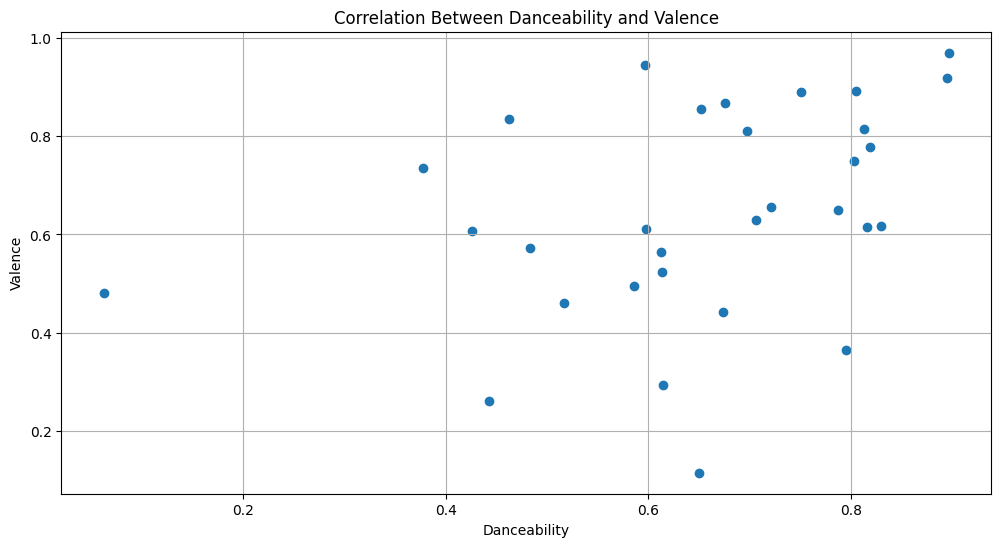

In [24]:
plt.figure(figsize=(12, 6))
# Plotting danceability and valence
plt.scatter(playlist_df['danceability'], playlist_df['valence'])
plt.title('Correlation Between Danceability and Valence')
plt.xlabel('Danceability')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

In [27]:
correlation_coefficient = playlist_df['danceability'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.356678363921309


hmm. some degree of correlation. 

### Is there correlation between danceability and loudness?

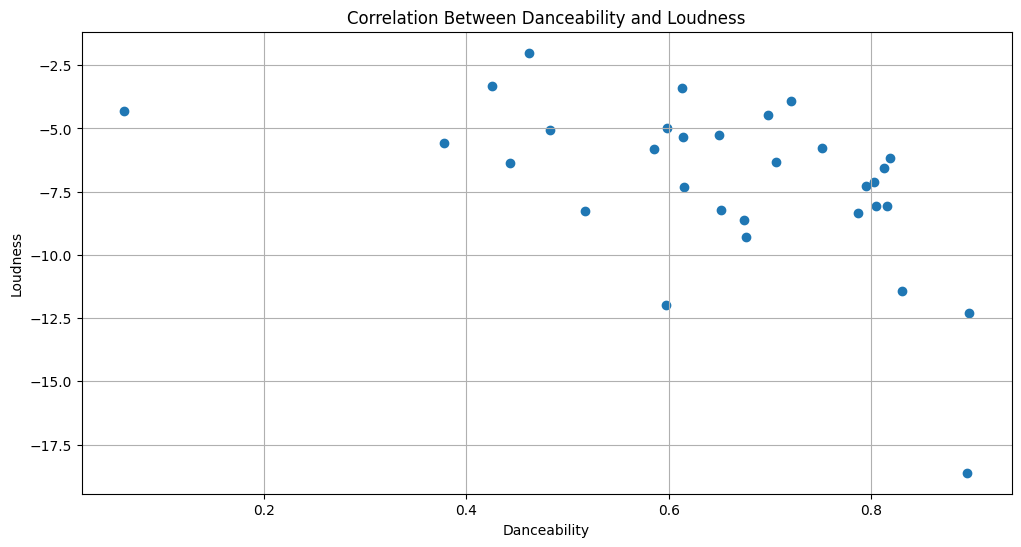

In [28]:
plt.figure(figsize=(12, 6))
# Plotting danceability and valence
plt.scatter(playlist_df['danceability'], playlist_df['loudness'])
plt.title('Correlation Between Danceability and Loudness')
plt.xlabel('Danceability')
plt.ylabel('Loudness')
plt.grid(True)
plt.show()

In [29]:
correlation_coefficient = playlist_df['danceability'].corr(playlist_df['loudness'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: -0.5196557802751525


Moderate negative correlation

# Sentiment Analysis on the track names 

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to each tweet track name in playlist 
playlist_df['vader_score'] = playlist_df['name'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

In [29]:
playlist_df.head(20)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_href,analysis_url,duration_ms,time_signature,name,artists,genres,popularity,explicit,vader_score
0,0.8950,0.309,10,-18.614,1,0.0911,0.9360,0.966000,0.0826,0.919,...,https://api.spotify.com/v1/tracks/4RBVWdDXchRI...,https://api.spotify.com/v1/audio-analysis/4RBV...,153277,4,Teenage Dream x Put Your Records On,[Darcy Stokes],[],0,False,0.2500
1,0.4260,0.872,10,-3.322,1,0.1150,0.0191,0.000000,0.2690,0.608,...,https://api.spotify.com/v1/tracks/0oigSejhoNen...,https://api.spotify.com/v1/audio-analysis/0oig...,187693,4,Hollywood Baby,[100 gecs],"[bubblegum bass, hyper-rock, hyperpop, proto-h...",60,True,0.0000
2,0.8160,0.375,7,-8.053,1,0.0996,0.6070,0.000009,0.0933,0.615,...,https://api.spotify.com/v1/tracks/451GvHwY99NK...,https://api.spotify.com/v1/audio-analysis/451G...,191907,4,Banana Pancakes,[Jack Johnson],[neo mellow],71,False,0.0000
3,0.3780,0.638,10,-5.576,1,0.0750,0.0200,0.000077,0.0849,0.735,...,https://api.spotify.com/v1/tracks/7a86XRg84qja...,https://api.spotify.com/v1/audio-analysis/7a86...,250627,4,We Are Young (feat. Janelle Monáe),"[fun., Janelle Monáe]","[baroque pop, metropopolis, afrofuturism, alte...",74,False,0.0000
4,0.4830,0.777,4,-5.049,1,0.0618,0.0170,0.000019,0.2090,0.572,...,https://api.spotify.com/v1/tracks/1Pyxh8ERS8ao...,https://api.spotify.com/v1/audio-analysis/1Pyx...,252560,4,Sour Patch Kids,[Bryce Vine],[indie pop rap],0,True,0.0000
5,0.7870,0.655,6,-8.339,0,0.0431,0.2380,0.000171,0.1380,0.650,...,https://api.spotify.com/v1/tracks/6shRGWCtBUOP...,https://api.spotify.com/v1/audio-analysis/6shR...,208653,4,Upside Down,[Jack Johnson],[neo mellow],71,False,0.0000
6,0.6140,0.840,7,-5.355,1,0.1090,0.0436,0.000416,0.3000,0.524,...,https://api.spotify.com/v1/tracks/4x0ZEnpVD3ve...,https://api.spotify.com/v1/audio-analysis/4x0Z...,168962,4,Pickles from the Jar,[Courtney Barnett],"[art pop, australian indie, chamber pop, indie...",1,False,0.0000
7,0.6520,0.568,7,-8.205,1,0.0363,0.4820,0.000000,0.0945,0.856,...,https://api.spotify.com/v1/tracks/07gqJjvwwuZ1...,https://api.spotify.com/v1/audio-analysis/07gq...,117667,4,Dance Music,[The Mountain Goats],"[anti-folk, chamber pop, folk punk, indie rock...",0,False,0.0000
8,0.6150,0.658,5,-7.299,1,0.0343,0.0960,0.000911,0.2050,0.293,...,https://api.spotify.com/v1/tracks/3n69hLUdIsSa...,https://api.spotify.com/v1/audio-analysis/3n69...,227080,4,Breezeblocks,[alt-J],"[indie rock, indietronica, modern alternative ...",71,False,0.0000
9,0.5170,0.481,5,-8.273,1,0.0272,0.0293,0.000018,0.0903,0.461,...,https://api.spotify.com/v1/tracks/6JnufVNLIO5F...,https://api.spotify.com/v1/audio-analysis/6Jnu...,246973,4,Little Lion Man,[Mumford & Sons],"[modern folk rock, modern rock, neo mellow, st...",0,True,0.0000


Many of the Vader scores on track titles are zero, which is strange but likely due to the fact that Vader sentiment analysis relies heavily on individual word polarities and might struggle with abstract or context-dependent language in track titles.

In [30]:
# pull out top 5 highest vader scores

# Sort the DataFrame by 'vader_score' column in descending order
top_5_tracks = playlist_df.sort_values(by='vader_score', ascending=False).head(5)

# Select columns
top_5_tracks = top_5_tracks[['name', 'vader_score']]
print(top_5_tracks)


                     name  vader_score
16         Left Hand Free       0.7579
27               New Love       0.6369
20         Love Of A Girl       0.6369
24  Pocketful of Sunshine       0.4939
23    Walking On Sunshine       0.4939


In [31]:
# Compare this to the top 5 valence scores
top_5_valence = playlist_df.sort_values(by='valence', ascending=False).head(5)

# Select columns
top_5_valence = top_5_valence[['name', 'valence']]
print(top_5_valence)

                                   name  valence
29                               Talent    0.970
23                  Walking On Sunshine    0.944
0   Teenage Dream x Put Your Records On    0.919
27                             New Love    0.892
14                             Playlist    0.891


## Two of the top 5 positive sentiment scores are also two of the top 5 valence scores

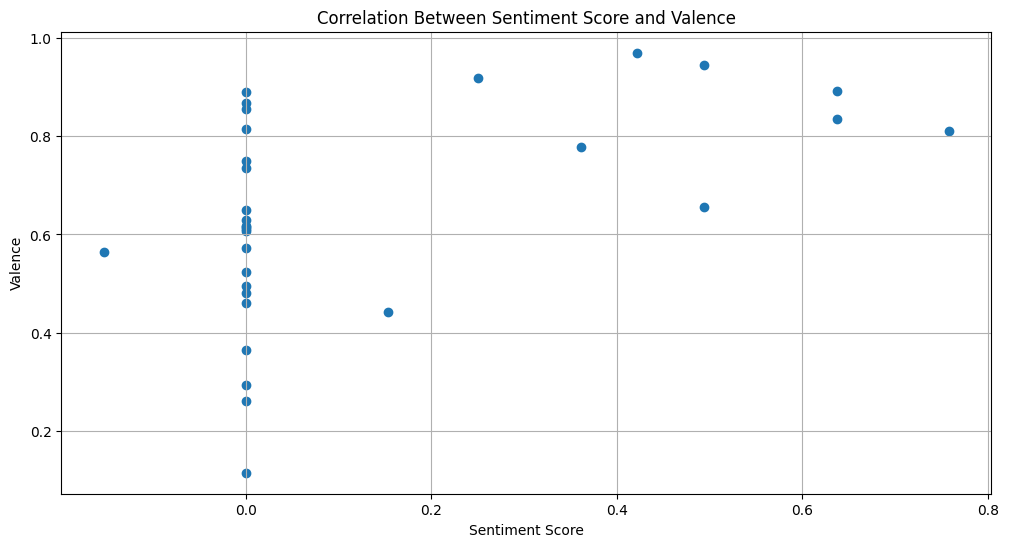

In [32]:
### Correlation between sentiment score and valence

plt.figure(figsize=(12, 6))
# Plotting danceability and valence
plt.scatter(playlist_df['vader_score'], playlist_df['valence'])
plt.title('Correlation Between Sentiment Score and Valence')
plt.xlabel('Sentiment Score')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

In [33]:
correlation_coefficient = playlist_df['vader_score'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.5015219814527155


Moderate correlation between the two. 

## Because vader did not assign scores to every title, we'll use word embeddings to find the cosine similarity between each title and 'happy'

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import gensim.downloader as api
import numpy as np

# Load Word2Vec model
model = api.load("word2vec-google-news-300")

# Track names
track_names = playlist_df['name']

# Word to compare with
word_to_compare = "happy"

# Tokenize track names
tokenized_track_names = [name.lower().split() for name in track_names]

# Compute Word2Vec embeddings for each track name
track_name_embeddings = []
for tokens in tokenized_track_names:
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        track_name_embeddings.append(np.mean(embeddings, axis=0))
    else:
        track_name_embeddings.append(np.zeros(300))  # Use zero vector if no words found in model

# Compute Word2Vec embedding for the word "happy"
happy_embedding = model[word_to_compare]

# Calculate cosine similarity between "happy" and each track name
cos_similarities = cosine_similarity([happy_embedding], track_name_embeddings)

# Print cosine similarities
for track_name, cos_sim in zip(track_names, cos_similarities[0]):
    print(f"Cosine similarity between 'happy' and '{track_name}': {cos_sim}")


In [31]:
# Calculate cosine similarities
cos_similarities = cosine_similarity([happy_embedding], track_name_embeddings)[0]

# Find mean, max, and min
mean_cos_similarity = np.mean(cos_similarities)
max_cos_similarity = np.max(cos_similarities)
min_cos_similarity = np.min(cos_similarities)

print(f"Mean cosine similarity: {mean_cos_similarity}")
print(f"Max cosine similarity: {max_cos_similarity}")
print(f"Min cosine similarity: {min_cos_similarity}")


Mean cosine similarity: 0.19726241621914975
Max cosine similarity: 0.6263402295851772
Min cosine similarity: 0.0


In [32]:
# Sort cosine similarities in descending order and get indices
top_5_indices = np.argsort(cos_similarities)[::-1][:5]

# Extract top 5 track names and their cosine similarities
top_5_track_names = [track_names[i] for i in top_5_indices]
top_5_cos_similarities = [cos_similarities[i] for i in top_5_indices]

# Print top 5 track names and their cosine similarities
print("Top 5 tracks with highest cosine similarities:")
for track_name, cos_sim in zip(top_5_track_names, top_5_cos_similarities):
    print(f"Track: {track_name}, Cosine Similarity: {cos_sim}")


Top 5 tracks with highest cosine similarities:
Track: Happy til it hurts, Cosine Similarity: 0.6263402295851772
Track: New Love, Cosine Similarity: 0.36707484067287044
Track: We Are Young (feat. Janelle Monáe), Cosine Similarity: 0.3193119215682559
Track: smile more, Cosine Similarity: 0.30702185115594166
Track: Love Of A Girl, Cosine Similarity: 0.30283395280492814


In [33]:
# Get the valence scores of the top 5 tracks
top_5_valence_scores = playlist_df.loc[top_5_indices, 'valence']

# Print the top 5 track names, their cosine similarities, and their valence scores
print("Top 5 tracks with highest cosine similarities and their valence scores:")
for track_name, cos_sim, valence_score in zip(top_5_track_names, top_5_cos_similarities, top_5_valence_scores):
    print(f"Track: {track_name}, Cosine Similarity: {cos_sim}, Valence Score: {valence_score}")


Top 5 tracks with highest cosine similarities and their valence scores:
Track: Happy til it hurts, Cosine Similarity: 0.6263402295851772, Valence Score: 0.443
Track: New Love, Cosine Similarity: 0.36707484067287044, Valence Score: 0.892
Track: We Are Young (feat. Janelle Monáe), Cosine Similarity: 0.3193119215682559, Valence Score: 0.735
Track: smile more, Cosine Similarity: 0.30702185115594166, Valence Score: 0.778
Track: Love Of A Girl, Cosine Similarity: 0.30283395280492814, Valence Score: 0.836


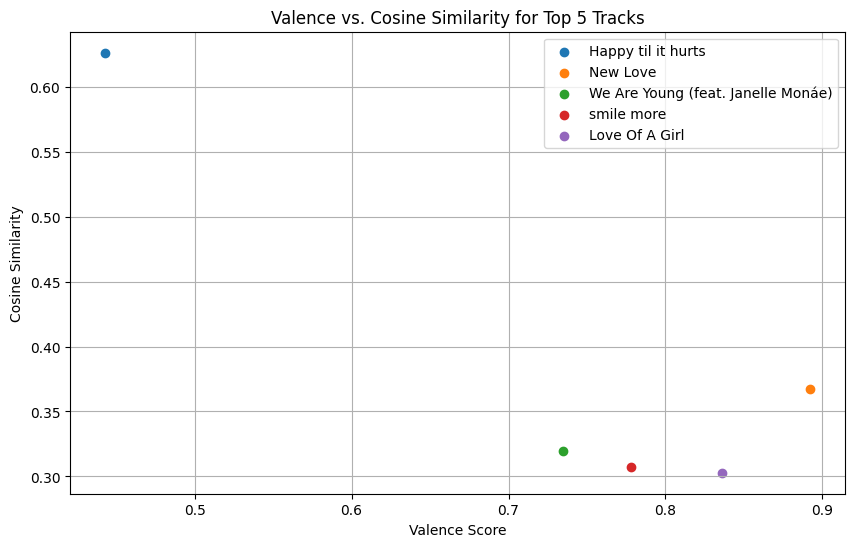

In [34]:
# Get the valence scores of all tracks
all_valence_scores = playlist_df['valence']

# Plot
plt.figure(figsize=(10, 6))

# Plot each track
for track_name, cos_sim, valence_score in zip(top_5_track_names, top_5_cos_similarities, top_5_valence_scores):
    plt.scatter(valence_score, cos_sim, label=track_name)

# Add labels and legend
plt.xlabel('Valence Score')
plt.ylabel('Cosine Similarity')
plt.title('Valence vs. Cosine Similarity for Top 5 Tracks')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [35]:
# Add cosine similarity scores as a new column to playlist_df
playlist_df['cosine_similarity'] = cos_similarities

correlation_coefficient = playlist_df['cosine_similarity'].corr(playlist_df['valence'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.046244403124782854


## Representing Correlation but Looking at the Top 10

Top 10 tracks with highest cosine similarities:
Track: Happy til it hurts, Cosine Similarity: 0.6263402295851772
Track: New Love, Cosine Similarity: 0.36707484067287044
Track: We Are Young (feat. Janelle Monáe), Cosine Similarity: 0.3193119215682559
Track: smile more, Cosine Similarity: 0.30702185115594166
Track: Love Of A Girl, Cosine Similarity: 0.30283395280492814
Track: Teenage Dream x Put Your Records On, Cosine Similarity: 0.262347504249465
Track: Oysters In My Pocket, Cosine Similarity: 0.258656095176811
Track: Gee Willikers, Cosine Similarity: 0.2552562965798302
Track: Omaha (The Only What If), Cosine Similarity: 0.24605789534785721
Track: Little Lion Man, Cosine Similarity: 0.2451416663467207
Top 10 tracks with highest cosine similarities and their valence scores:
Track: Happy til it hurts, Cosine Similarity: 0.6263402295851772, Valence Score: 0.443
Track: New Love, Cosine Similarity: 0.36707484067287044, Valence Score: 0.892
Track: We Are Young (feat. Janelle Monáe), Cosine S

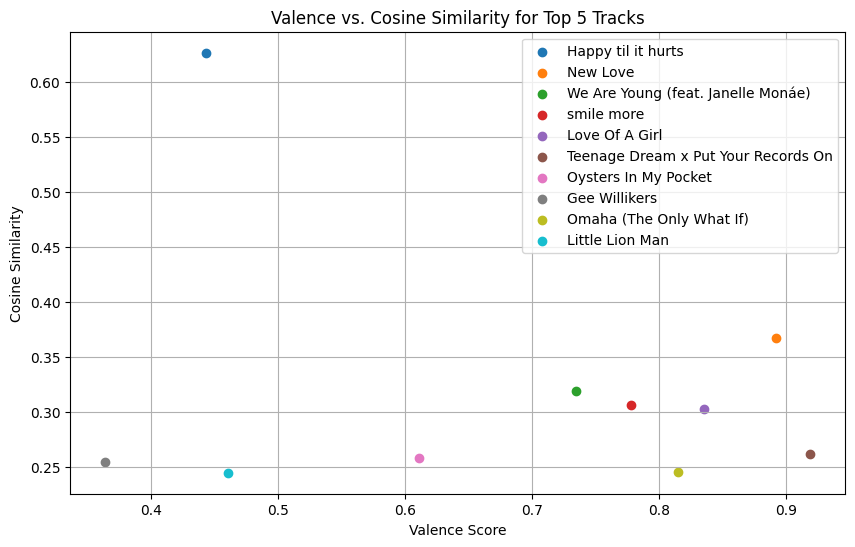

In [37]:
# Sort cosine similarities in descending order and get indices
top_10_indices = np.argsort(cos_similarities)[::-1][:10]

# Extract top 10 track names and their cosine similarities
top_10_track_names = [track_names[i] for i in top_10_indices]
top_10_cos_similarities = [cos_similarities[i] for i in top_10_indices]

# Print top 10 track names and their cosine similarities
print("Top 10 tracks with highest cosine similarities:")
for track_name, cos_sim in zip(top_10_track_names, top_10_cos_similarities):
    print(f"Track: {track_name}, Cosine Similarity: {cos_sim}")

# Get the valence scores of the top 10 tracks
top_10_valence_scores = playlist_df.loc[top_10_indices, 'valence']

# Print the top 5 track names, their cosine similarities, and their valence scores
print("Top 10 tracks with highest cosine similarities and their valence scores:")
for track_name, cos_sim, valence_score in zip(top_10_track_names, top_10_cos_similarities, top_10_valence_scores):
    print(f"Track: {track_name}, Cosine Similarity: {cos_sim}, Valence Score: {valence_score}")

# Get the valence scores of all tracks
all_valence_scores = playlist_df['valence']

# Plot
plt.figure(figsize=(10, 6))

# Plot each track
for track_name, cos_sim, valence_score in zip(top_10_track_names, top_10_cos_similarities, top_10_valence_scores):
    plt.scatter(valence_score, cos_sim, label=track_name)

# Add labels and legend
plt.xlabel('Valence Score')
plt.ylabel('Cosine Similarity')
plt.title('Valence vs. Cosine Similarity for Top 5 Tracks')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

No correlation

## Running Some Statistical Analysis For Playlists

In [30]:
# sad playlist: https://open.spotify.com/playlist/37i9dQZF1EIdChYeHNDfK5?si=812028350420478c
sad_id = '37i9dQZF1EIdChYeHNDfK5'
# happy playlist: https://open.spotify.com/playlist/37i9dQZF1EIfAiavURxjpo?si=8fa48b74ffef425d
happy_id = '37i9dQZF1EIfAiavURxjpo'
# angry playlist: https://open.spotify.com/playlist/37i9dQZF1EIhuCNl2WSFYd?si=ade7b6ce10144714
angry_id = '37i9dQZF1EIhuCNl2WSFYd'

happy_df = get_playlist_data(happy_id)
sad_df = get_playlist_data(sad_id)
angry_df = get_playlist_data(angry_id)

In [31]:
# set up labels to classify which playlist they're on
happy_df['playlist'] = 'happy'
sad_df['playlist'] = 'sad'
angry_df['playlist'] = 'angry'

# combine them
combined_df = pd.concat([happy_df, sad_df, angry_df], axis=0)

In [32]:
# set up the dataframe
pca_df = combined_df

# now make the dataframe only numerical values
# Filter columns based on numeric data type (float or int)
numeric_columns = pca_df.select_dtypes(include=['number']).columns

# Create a copy of the DataFrame with only numeric columns
numeric_df = pca_df[numeric_columns].copy()

In [33]:
numeric_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,0.826,0.490,9,-10.477,1,0.0676,0.00916,0.000004,0.0415,0.627,74.128,180267,4,80
1,0.608,0.768,0,-5.227,1,0.0475,0.09130,0.000000,0.0629,0.809,88.059,244880,4,76
2,0.491,0.583,7,-10.964,1,0.0376,0.18500,0.000000,0.4060,0.908,150.566,183307,4,85
3,0.814,0.373,7,-8.017,1,0.1160,0.60200,0.000017,0.0931,0.632,114.548,191907,4,72
4,0.659,0.615,11,-5.865,0,0.0644,0.27000,0.000000,0.1870,0.193,119.843,164010,4,74


In [34]:
# scale the dataframe
from sklearn.preprocessing import StandardScaler

# Exercise 2.2
df_scaled = numeric_df.copy()

for column in df_scaled:
    scaler = StandardScaler()
    scaler.fit(df_scaled[column].values.reshape(-1,1))
    df_scaled[column] = scaler.transform(df_scaled[column].values.reshape(-1,1))

In [35]:
import numpy as np
# calculate the covariance matrix
cov_matrix = np.cov(df_scaled, rowvar=False)
print(cov_matrix.shape) # checking to make sure that it's square

(14, 14)


The covariance matrix is a measure of how much each of the dimensions of the data vary from the mean in relation to each other.

In [36]:
# calculate the eigenvectors and eigenvalues
eigen = np.linalg.eig(cov_matrix)

# sort them by descending order
eigenvals_sorted = np.sort(eigen[0])[::-1]
eigenvectors_sorted = []
for val in eigenvals_sorted:
    index = np.where(eigen[0] == val)
    vector = eigen[1][index]
    eigenvectors_sorted.append(vector)

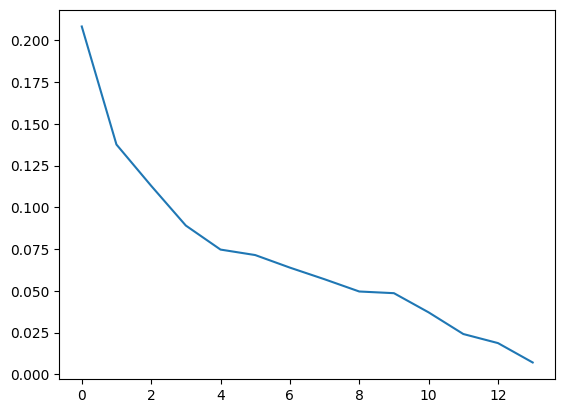

In [37]:
# get the ratios to visualize the explained variance, telling us how much information can be attributed to the principal components
ratios = []
for val in eigenvals_sorted:
    
    ratio = val / (eigenvals_sorted.sum())
    ratios.append(ratio)

plt.plot(ratios)

In [38]:
# transform the data using the first two eigenvectors
eigs = np.array(eigenvectors_sorted[:2]).reshape(2, 14)
print(eigs.T.shape)

PCA_data = np.dot(df_scaled, eigs.T)

(14, 2)


In [39]:
# visualize the PCA
import seaborn as sns

df_pca = pd.DataFrame(PCA_data, columns=['PC_1', 'PC_2'])

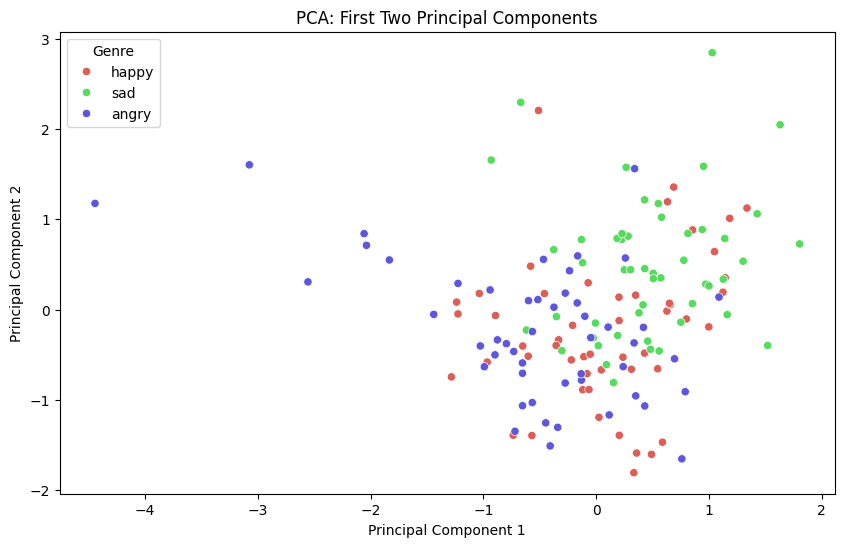

In [40]:
# visualize the PCA
import seaborn as sns

df_pca = pd.DataFrame(PCA_data, columns=['PC_1', 'PC_2'])
df_pca.head()
combined_df_reset = combined_df.reset_index(drop=True)
df_pca['playlist'] = combined_df_reset['playlist']

# Plotting the principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='playlist', palette='hls')
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Genre')
plt.show()

### Using k-Means clustering to see if we can predict the playlist that a song is in

In [41]:
# define our distance function
def euclidean_distance(x, y):
    sum = 0
    for i in range(len(x)):
        diff = np.square(x[i] - (y[i]))
        sum = sum + diff
    return np.sqrt(sum)

# define initialize centroids for the K-means algorithm
import random
def initialize_centroids(data, k):
    centroids = []
    i = 0
    for i in range(k):
        rand_point = random.choice(data)
        # i here is the label, just to keep track of the centroids
        centroids.append([rand_point, i])
        i+=1
    return centroids

# define assign_points for the kNN algorithm
def assign_points(data, centroids):
    labels = []
    for point in data:
        distances = []
        for centroid in centroids:
            dist = euclidean_distance(point, centroid[0])
            distances.append([dist, centroid])
        minimum_dist = min(distances, key=lambda x: x[0])
        labels.append([point, minimum_dist[1]])
    return labels

# define update_centroids for the kmeans algorithm
def update_centroids(data, labels, k):
    new_centroids = []
    for i in range(k):
        cluster = [data[l] for l in range(len(data)) if labels[l] == i]
        if len(cluster) > 0:
            new_centroid = np.mean(cluster, axis=0)
            new_centroids.append(new_centroid)
        # if there's no points for this label, just add back a new random centroid (super unlikely but possible)
        else:
            rand_point = random.choice(data)
            new_centroids.append([rand_point, i])
    return new_centroids

# define our kmeans algorithm
def kmeans(data, k, max_iter=100):
    centroids = initialize_centroids(data, k)
    for i in range(max_iter):
        labels = assign_points(data, centroids)
        new_centroids = update_centroids(data, labels, k)

        # see if there has been convergence
        convergence = 0
        for old, new in zip(centroids, new_centroids):
            if euclidean_distance(new[0], old[0]) < 1e-4:
                convergence += 1
        if convergence == len(centroids):
            break
        else:
            centroids = new_centroids
    return centroids, labels

In [42]:
# set up the dataframe
pca_df = combined_df

# now make the dataframe only numerical values
# Filter columns based on numeric data type (float or int)
numeric_columns = pca_df.select_dtypes(include=['number']).columns

# Create a copy of the DataFrame with only numeric columns
numeric_df = pca_df[numeric_columns].copy()

# scale all the values in the dataframe
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
df_kmeans = pd.DataFrame(scaled_data, columns=numeric_df.columns)

# figure out the artist size
playlist_size = pca_df['playlist'].nunique()
k = playlist_size

# run the kmeans algorithm on df_kmeans
data = df_kmeans.values
centroids, labels = kmeans(data, k)

Cluster label with the largest size: 0
Size of cluster: 85
Cluster label with the second largest size: 1
Size of cluster: 46


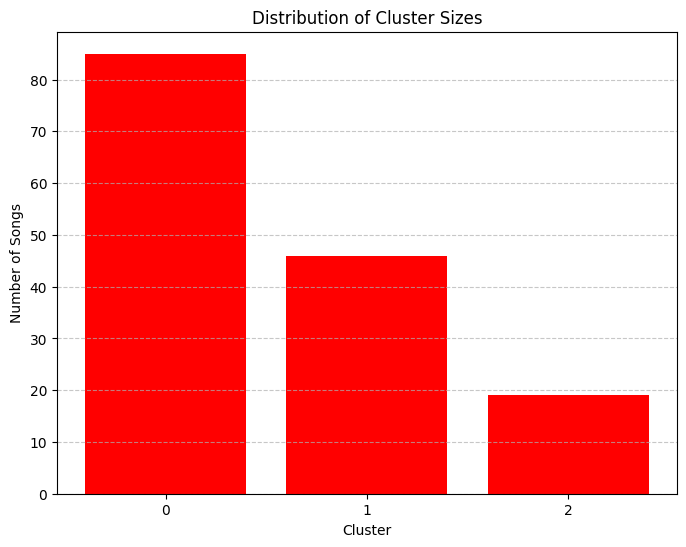

In [43]:
# visualize the labels
clusters = [labels[i][1][1] for i in range(len(labels))]
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
largest_cluster = cluster_sizes.idxmax()
print("Cluster label with the largest size:", largest_cluster)
print("Size of cluster:", cluster_sizes[largest_cluster])
second = cluster_sizes.drop(largest_cluster).idxmax()
print("Cluster label with the second largest size:", second)
print("Size of cluster:", cluster_sizes[second])

plt.figure(figsize=(8, 6))
plt.bar(cluster_sizes.index, cluster_sizes.values, color='red')
plt.xlabel('Cluster')
plt.ylabel('Number of Songs')
plt.title('Distribution of Cluster Sizes')
plt.xticks(cluster_sizes.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [44]:
# figuring out the purity of the clusters
from collections import Counter
# figure out which artist had their songs classified the best
ratios = []
i = 0
for i in range(playlist_size):
    cluster_list = [labels[j] for j in range(len(labels)) if labels[j][1][1] == i]
    cluster_indices = []
    for l in range(len(cluster_list)):
        row = cluster_list[l][0]
        index_of_row = df_kmeans[df_kmeans.eq(row).all(axis=1)].index[0]
        cluster_indices.append(index_of_row)
    playlist_names = []
    for index in cluster_indices:
        playlist_names.append(combined_df.iloc[index]['playlist'])
    playlist_counts = pd.Series(playlist_names).value_counts().sort_index()
    size = len(cluster_list)
    most_common_playlist = playlist_counts.idxmax()
    frequency = playlist_counts[most_common_playlist]
    ratios.append([most_common_playlist, frequency / len(cluster_list), size])
print(ratios)

[['angry', 0.4823529411764706, 85], ['sad', 0.5652173913043478, 46], ['sad', 0.5789473684210527, 19]]


It doesn't predict any of the clusters particularly well

# Taking the metadata and representing it as art

In [45]:
# find color pallete 
from pylab import *

cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))

cmap = cm.get_cmap('plasma', 101)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
print(color_list)

#00004c
#0000ff
#ffffff
#ff0000
#800000
['#0d0887', '#130789', '#1b068d', '#20068f', '#260591', '#2a0593', '#2f0596', '#330597', '#38049a', '#3e049c', '#41049d', '#46039f', '#4903a0', '#4e02a2', '#5102a3', '#5601a4', '#5901a5', '#5e01a6', '#6300a7', '#6600a7', '#6a00a8', '#6e00a8', '#7201a8', '#7501a8', '#7a02a8', '#7e03a8', '#8104a7', '#8606a6', '#8808a6', '#8d0ba5', '#8f0da4', '#9410a2', '#9613a1', '#9a169f', '#9e199d', '#a11b9b', '#a51f99', '#a72197', '#ab2494', '#ad2793', '#b12a90', '#b32c8e', '#b6308b', '#ba3388', '#bc3587', '#bf3984', '#c13b82', '#c43e7f', '#c6417d', '#c9447a', '#cc4778', '#cd4a76', '#d04d73', '#d24f71', '#d5536f', '#d6556d', '#d9586a', '#da5b69', '#dd5e66', '#df6263', '#e16462', '#e3685f', '#e56a5d', '#e76e5b', '#e87059', '#ea7457', '#eb7655', '#ed7a52', '#ef7e50', '#f0804e', '#f2844b', '#f3874a', '#f58b47', '#f68d45', '#f79143', '#f89540', '#f9983e', '#fa9c3c', '#fb9f3a', '#fca338', '#fca636', '#fdab33', '#fdae32', '#fdb22f', '#feb72d', '#feba2c', '#febe2a', '#

/var/folders/m4/74vppbc12tv4dpy3k6tl3yhc0000gn/T/ipykernel_13268/2613399816.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors
/var/folders/m4/74vppbc12tv4dpy3k6tl3yhc0000gn/T/ipykernel_13268/2613399816.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', 101)


In [46]:
import matplotlib.colors as mcolors
import numpy as np

In [47]:
colors1 = ['#f7f4ed', '#f0c51c', '#ee7526', '#ef4255'] # Replace with your own

# Make a copy of colors1 array... more on why we do this later!
colors1_reverse = colors1[::]  
colors1_reverse.reverse()

In [48]:
# define num of bins for smoother gradient 
n_bins = len(colors1) * 200

In [49]:
# Creating a LinearSegmentedColormap 
def make_colormap(cmap_name, colors, num_bins=n_bins):
    """
    Given the name of colormap (string), a string list of colors in their hex values, and a number of bins
    (predetermined if not provided), generate, return, and display a colormap
    """
    # Generating a colormap
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=num_bins)

    # Create a one-dimensional array to serve as stand-in data so that the colormap may be displayed well
    gradient_multi = np.linspace(0, 1, 256)
    # Stacking one array on top of another to visually  thicken it
    gradient_multi = np.vstack((gradient_multi, gradient_multi)) 

    # Display colormap
    # Dpi = dots-per-inch (pixel density)
    plt.figure(figsize=(3, 1), dpi=300)  # 300 dpi is the ideal dpi for Spotify playlist covers *
    plt.imshow(gradient_multi, aspect='auto', cmap=cmap)
    plt.title(cmap_name)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
    return cmap

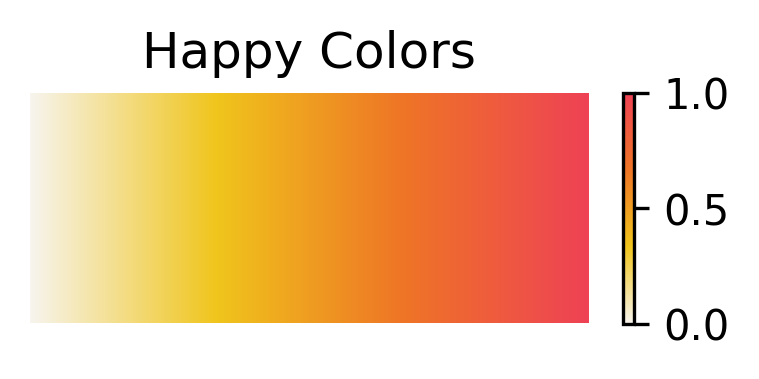

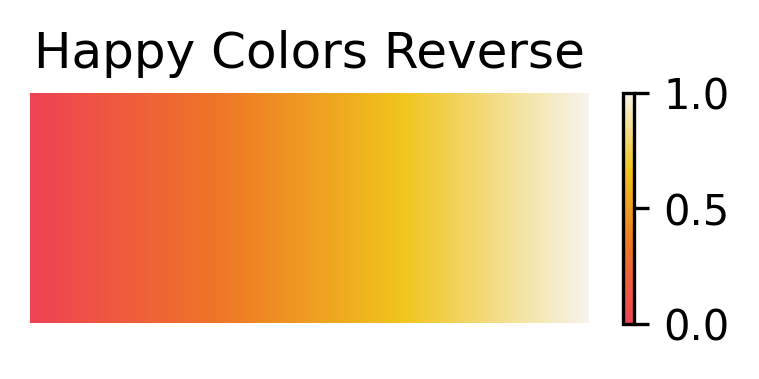

In [50]:
# Sample
cmap_name = 'Happy Colors'
happy_colors = make_colormap(cmap_name, colors1, n_bins)

cmap_name_reverse = 'Happy Colors Reverse'
happy_colors_reverse = make_colormap(cmap_name_reverse, colors1_reverse, n_bins)

In [51]:
figure_count = 0

def generate_artwork(df, x, y, cmap, weights):
    """
    Given a dataframe and the coordinates to be mapped onto the kernel density estimate (KDE) plot, generate a KDE
    plot to become the playlist art.
    """
    global figure_count
    
    plt.figure(figsize=(2, 2), dpi=300)
    fig = sns.kdeplot(data=df,       # Obtain data from the pandas dataframe provided
                x=x,                 # Choose variable and its corresponding data for x axis
                y=y,                 # Choose variable and its corresponding data for y axis
                cmap=cmap,           # Choose colormap to be used
                weights=weights,     # Choose data for which to weight the (x,y) coordinates
                thresh=0,            # 0 so as to display all data & not ignore any data
                levels=500,          # Similar to bins for a colormap; governs smoothness for KDE plot
                fill=True            # Fill in areas with no data
                )

    
    # Optionally, customize the plot with titles, labels, etc. 
#     plt.title('Playlist Aura')
#     plt.xlabel(x)
#     plt.ylabel(y)

    # Otherwise, comment out the above customization features & turn off the axis for just the image
    # plt.axis('off')

    # Display & save the plot to local folder!
    plt.show()
    
    if figure_count == 0:
        figure_title = "Playlist Aura.png"
        # fig.figure.savefig(figure_title, bbox_inches='tight')
    else:
        figure_title = "Playlist Aura(" + str(figure_count) + ").png"
        # fig.figure.savefig(figure_title, bbox_inches='tight')
    # Global var to keep track of how many figures have bee created so the saved images don't overwrite each other
    figure_count += 1

## Performing Some Comparison Between the KDE Plots of Different Playlists

In [52]:
# sad playlist: https://open.spotify.com/playlist/5tXZrk0D0LYxJJEFAKgELe?si=797362fc3aa34586
sad_id = '5tXZrk0D0LYxJJEFAKgELe'
# happy playlist: https://open.spotify.com/playlist/2kUlqhddlSFjPcY6FmK4qg?si=b44970c61a854064
happy_id = '2kUlqhddlSFjPcY6FmK4qg'

happy_df = get_playlist_data(happy_id)
sad_df = get_playlist_data(sad_id)

Peak of KDE: Value = 1.2571 at x = 0.19


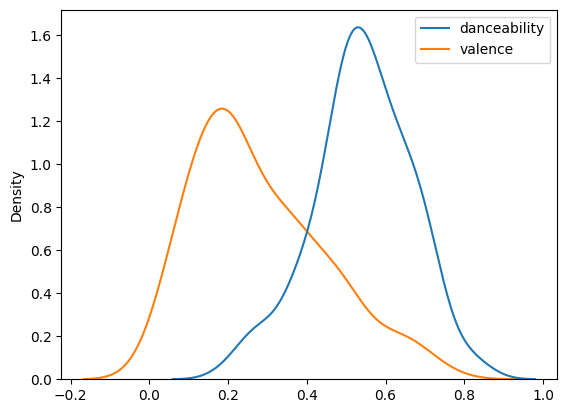

In [53]:
# Extract only two specific columns from the original DataFrame
desired_columns = ['danceability', 'valence']  # Specify the column names you want to keep
new_sad_df = sad_df[desired_columns].copy()
new_happy_df = happy_df[desired_columns].copy()

sad_ax = sns.kdeplot(new_sad_df)

# Extract the data from the plot
sad_kde_data = sad_ax.get_lines()[0].get_data()  # Get the x, y data of the KDE curve

# Print out the KDE values at specific x-points
sad_x_values = sad_kde_data[0]
sad_kde_values = sad_kde_data[1]  # KDE density values

# Find the peak(s) of the KDE
sad_max_kde_value = np.max(sad_kde_values)
sad_max_kde_index = np.argmax(sad_kde_values)
sad_peak_x_value = sad_x_values[sad_max_kde_index]
print(f"Peak of KDE: Value = {sad_max_kde_value:.4f} at x = {sad_peak_x_value:.2f}")

Peak of KDE: Value = 0.7854 at x = 0.62


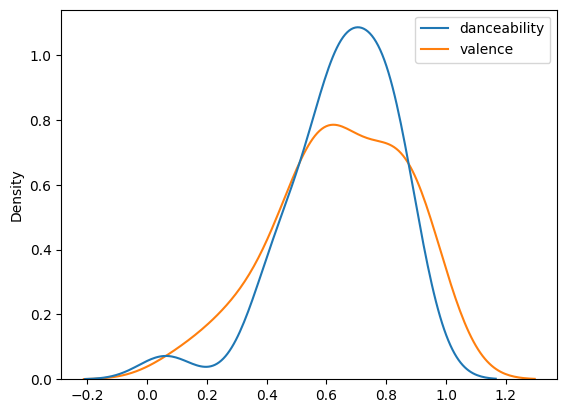

In [54]:
happy_ax = sns.kdeplot(new_happy_df)
happy_kde_data = happy_ax.get_lines()[0].get_data()  # Get the x, y data of the KDE curve
happy_x_values = happy_kde_data[0]
happy_kde_values = happy_kde_data[1]  # KDE density values
# Find the peak(s) of the KDE
happy_max_kde_value = np.max(happy_kde_values)
happy_max_kde_index = np.argmax(happy_kde_values)
happy_peak_x_value = happy_x_values[happy_max_kde_index]
print(f"Peak of KDE: Value = {happy_max_kde_value:.4f} at x = {happy_peak_x_value:.2f}")

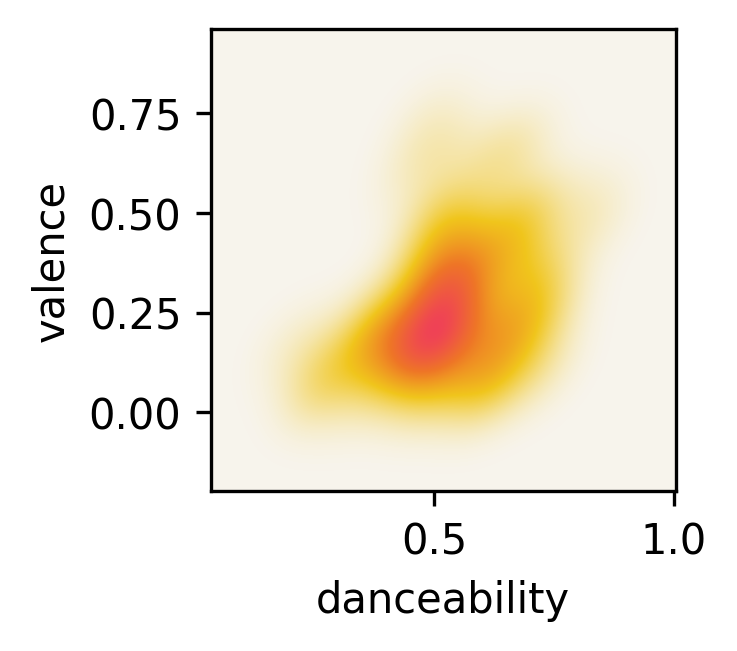

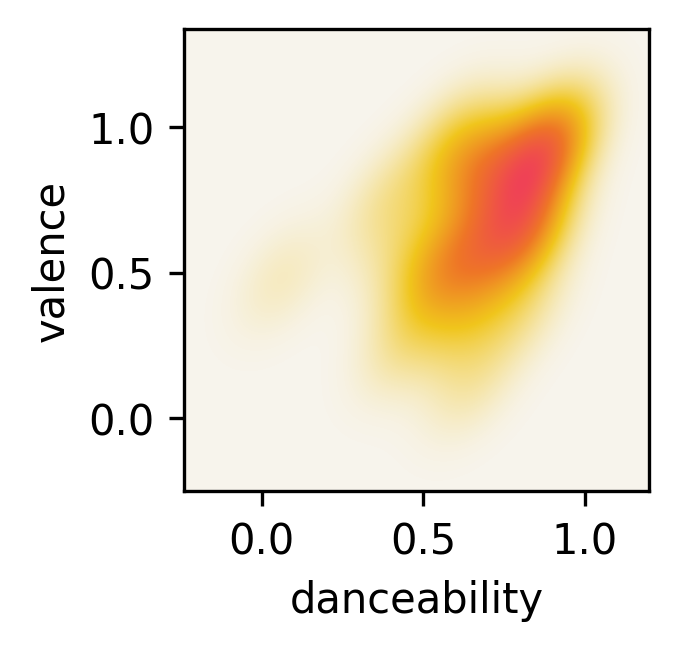

In [55]:
generate_artwork(sad_df, "danceability", "valence", happy_colors, "loudness")
generate_artwork(happy_df, "danceability", "valence", happy_colors, "loudness")

#### So we can see that there's a skew away from valence for the sad playlist compared to the first one and that the KDE peak is farther back

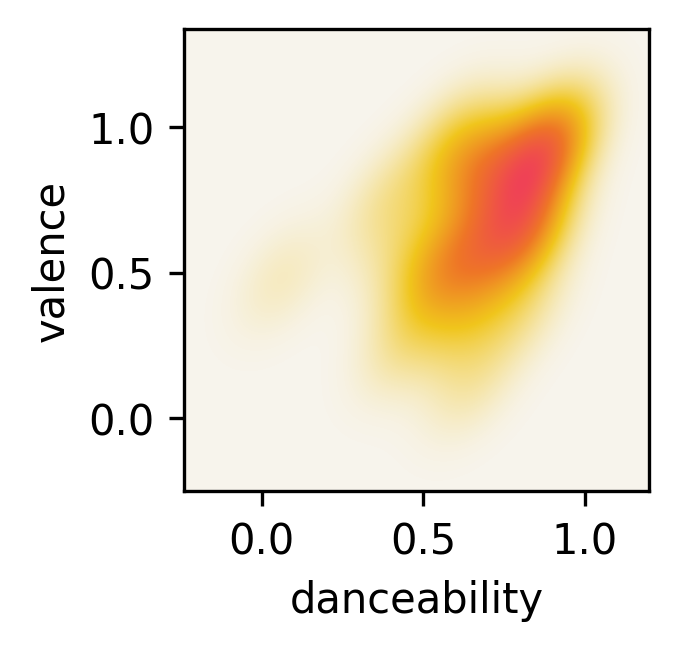

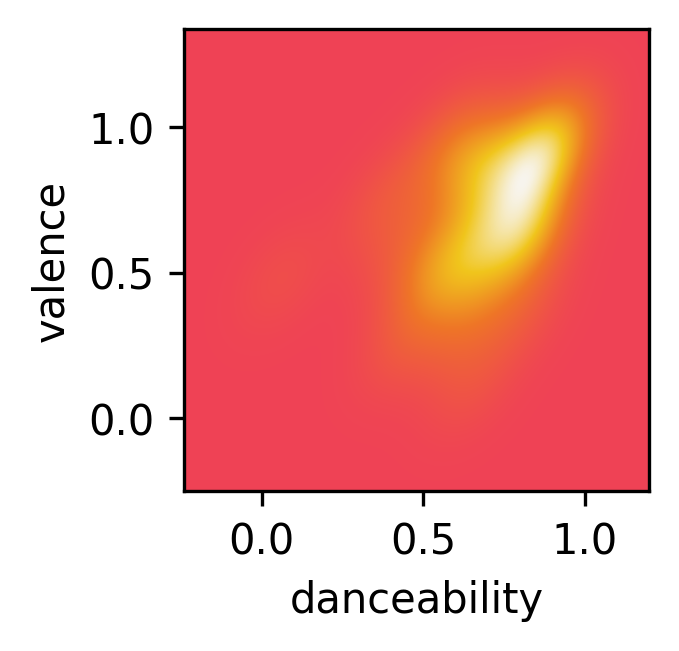

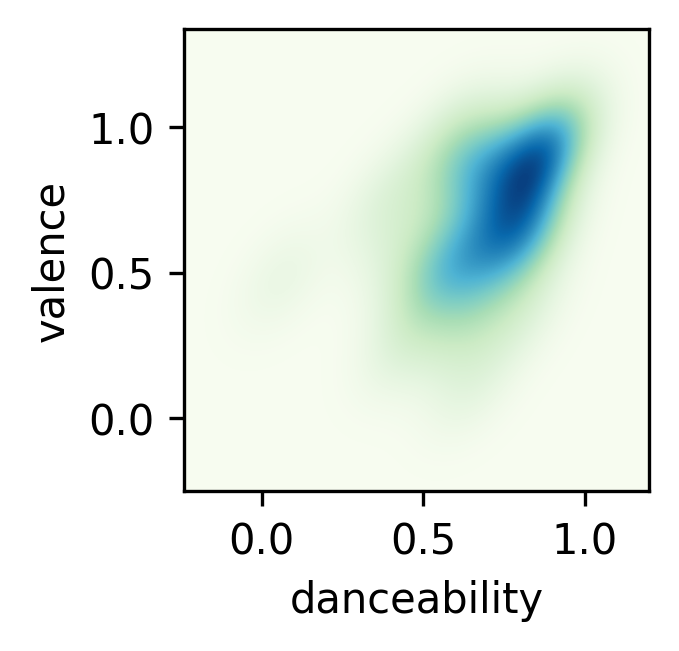

In [56]:
generate_artwork(playlist_df, "danceability", "valence", happy_colors, "loudness")
generate_artwork(playlist_df, "danceability", "valence", happy_colors_reverse, "loudness")
# GnBu is a mplt built-in colormap
generate_artwork(playlist_df, "danceability", "valence", "GnBu", "loudness") 

# Explaination of shape 

The shape generated by the Kernel Density Estimate (KDE) plot represents the density of data points in the feature space defined by the variables used: danceability and valence. KDE plots work by placing a kernel at each data point and summing these kernels to estimate the underlying probability density function. 

In these plots, the songs are represented by their positions in the feature space, with areas of higher density indicating where more songs cluster, thus providing insights into the distribution of songs based on their danceability, valence, and loudness.

# Making the artwork more representative of the playlist

In [57]:
def classify_valence(df):
    total_valence = 0
    num_tracks = len(df)
    happy_scheme = ['#f7f4ed', '#f0c51c', '#ee7526', '#ef4255']
    mid_scheme = ['#b4cee1', '#f6f3ff', '#d2ede6', '#b6b864']
    sad_scheme = ['#571074', '#1a34b1', '#a1dbf1', '#1c4670']

    for valence in df['valence']:
        total_valence += valence

    avg_valence = total_valence / num_tracks

    if avg_valence > 0.6:
        # Happy Color scheme
        cmap_name = 'Playlist Mood'
        mood_plot = make_colormap(cmap_name, happy_scheme, n_bins)
        generate_artwork(df, "danceability", "valence", mood_plot, "tempo") # add others
        
        
    elif 0.4 <= avg_valence <= 0.6:
        # mid color scheme
        cmap_name = 'Playlist Mood'
        mood_plot = make_colormap(cmap_name, mid_scheme, n_bins)
        generate_artwork(df, "danceability", "valence", mood_plot, "loudness") # add others
        
    else:
        cmap_name = 'Playlist Mood'
        mood_plot = make_colormap(cmap_name, sad_scheme, n_bins)
        generate_artwork(df, "danceability", "valence", mood_plot, "loudness") # add others
        
    

    print(avg_valence)

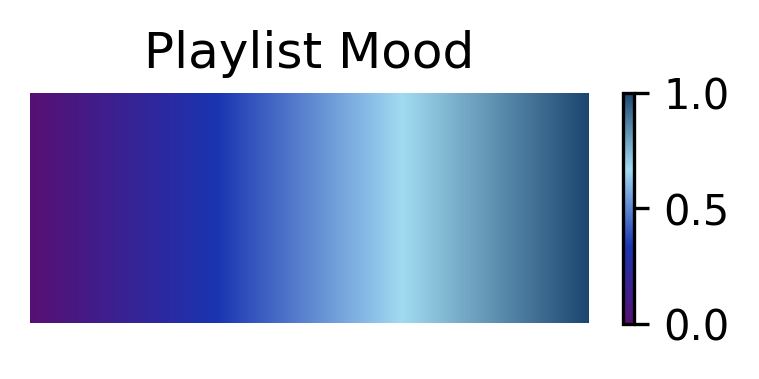

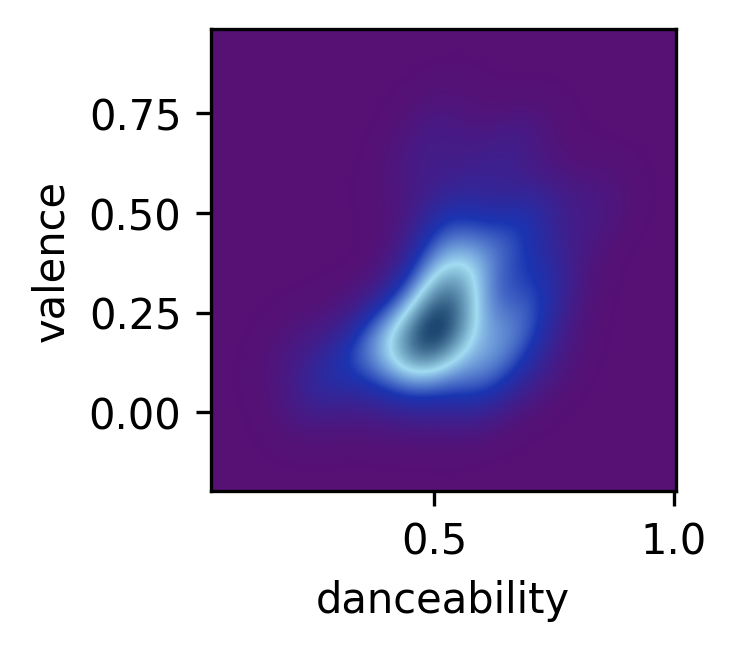

0.2800844444444444


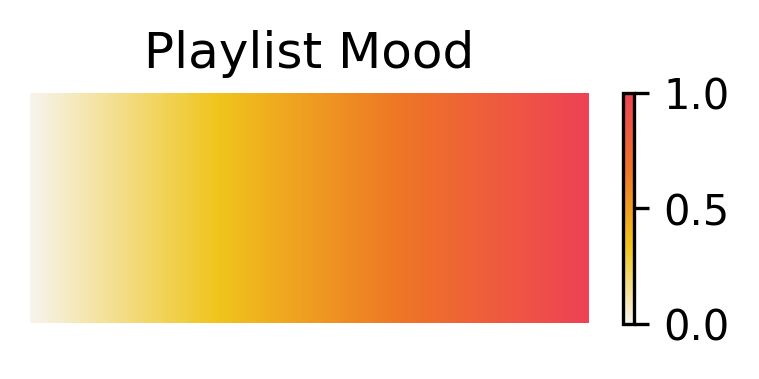

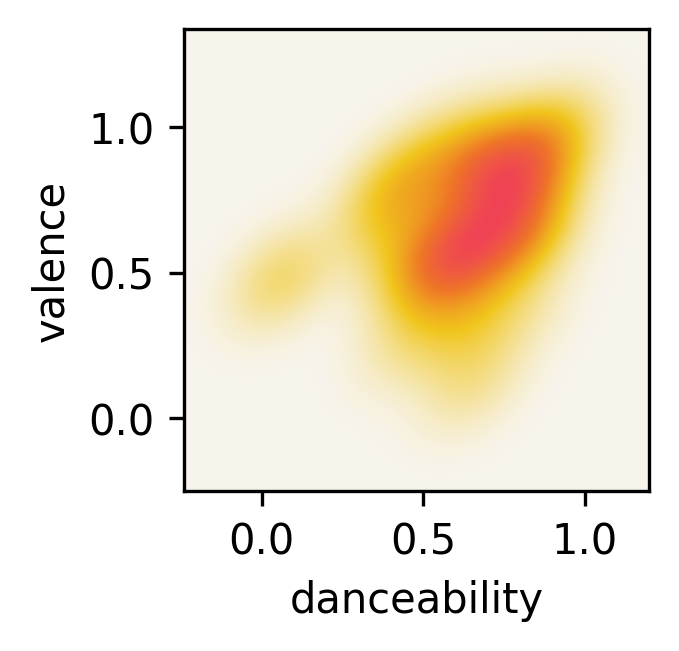

0.6458387096774193


In [58]:
# generate_artwork(sad_df, "danceability", "valence", happy_colors, "loudness")
# generate_artwork(happy_df, "danceability", "valence", happy_colors, "loudness")

classify_valence(sad_df)
classify_valence(happy_df)

In [59]:
playlist_id = '7fYwBA3tlbYZnKO4LPpUyT' 
wig_df = get_playlist_data(playlist_id)

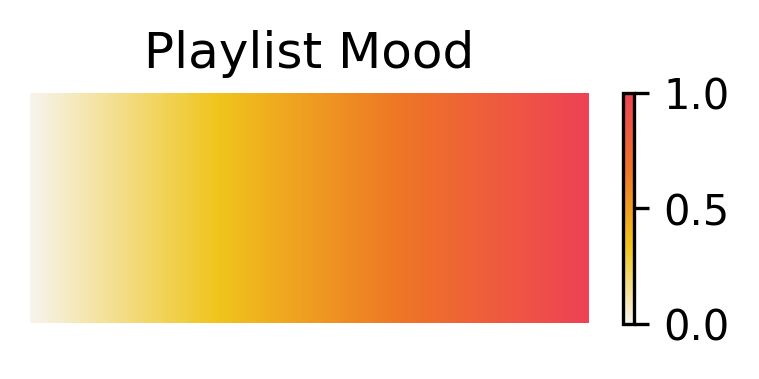

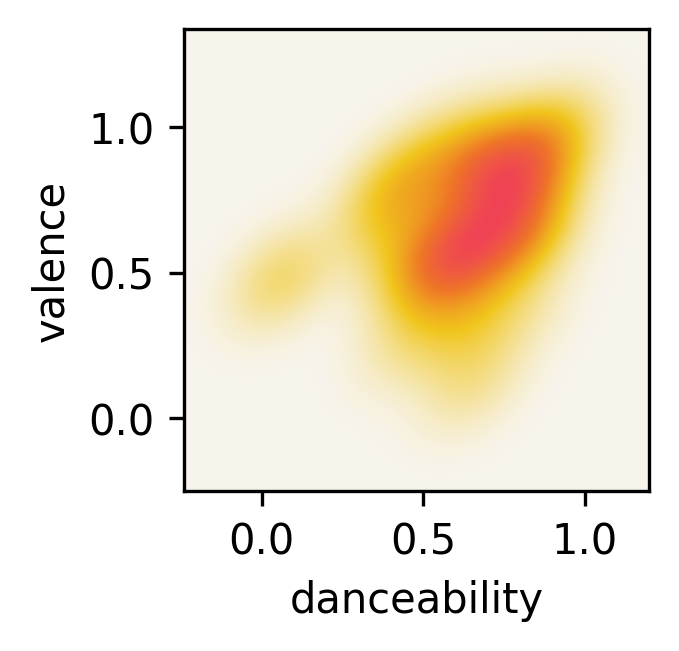

0.6458387096774193


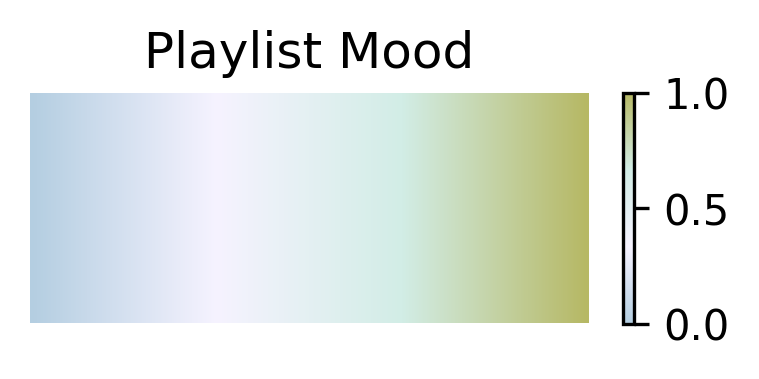

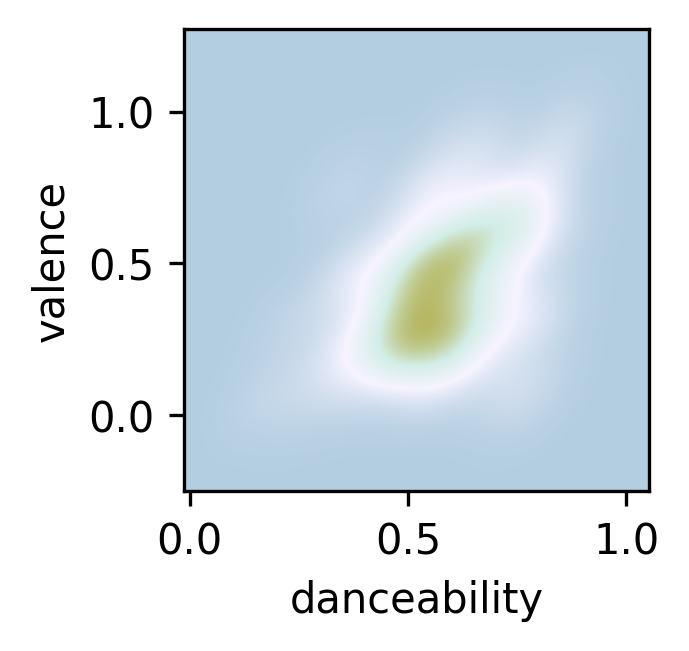

0.43945839416058374


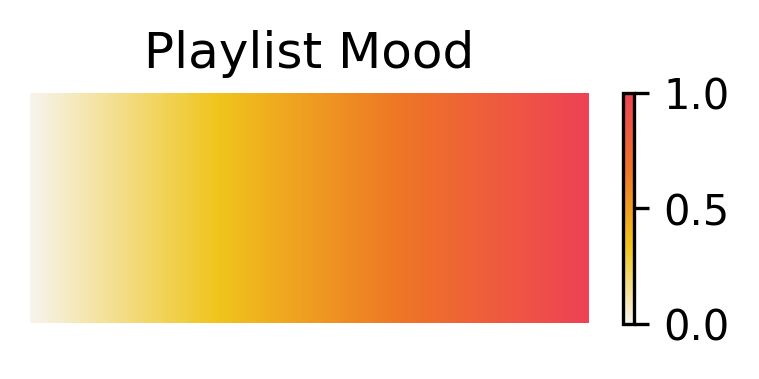

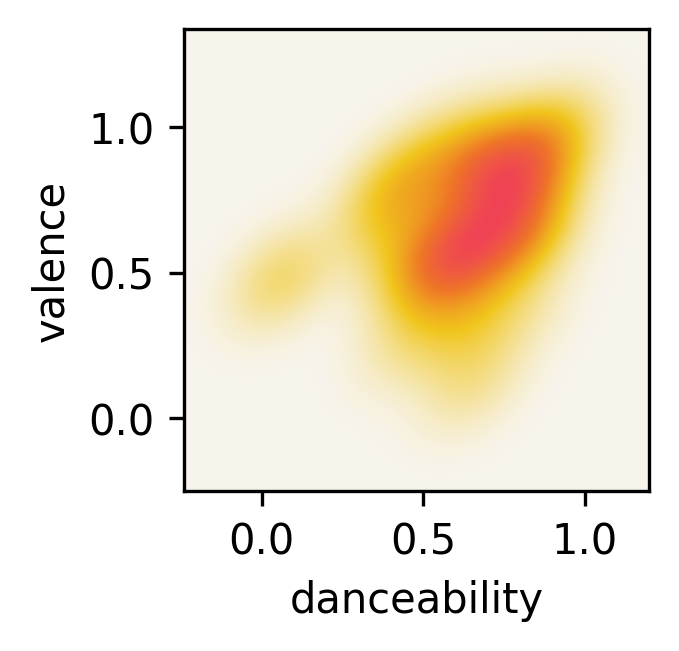

0.6458387096774193


In [60]:
classify_valence(playlist_df)
classify_valence(wig_df)
classify_valence(happy_df)